In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AI/lct
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AI/lct
archives		     CovidPatology	 production.py
cancer.ipynb		     data.ipynb		 __pycache__
configs			     Lung		 train_functions.py
Covid			     lung.ipynb		 Untitled0.ipynb
COVID19_1110.zip	     modeling		 utils
COVID-19-CT-Seg_20cases.zip  MSD		 weights
covid.ipynb		     OrganSegmentations


In [ ]:
#!g1.1
# Помощь в визуализации
!pip install wandb segmentation_models_pytorch albumentations -qqq

%matplotlib inline
from IPython.display import clear_output
from tqdm.notebook import tqdm, trange
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

# Базовые библиотеки
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Аугментации
import albumentations as A

# Torch
import torch
from torch import nn
from torch import optim
import segmentation_models_pytorch as smp

# Красивые графики
import wandb

print('Ready to work')

Ready to work


In [ ]:
!cat utils/datagenerator.py

In [ ]:
from utils.datagenerator import data_generator
d = data_generator(cfg)

# Data saving

In [ ]:
!unzip archives/rp_msk.zip -d /content
!unzip archives/rp_im.zip -d /content
!cp archives/tr_im.nii.gz /content/rp_im/10.nii.gz
!cp archives/tr_mask.nii.gz /content/rp_msk/10.nii.gz

In [ ]:
import glob
import os

result = glob.glob('/content/rp_im/*.nii.gz')
len(result)

10

In [ ]:
!ls /content/masks

coronacases_001.nii.gz	radiopaedia_10_85902_1.nii.gz
coronacases_002.nii.gz	radiopaedia_10_85902_3.nii.gz
coronacases_003.nii.gz	radiopaedia_14_85914_0.nii.gz
coronacases_004.nii.gz	radiopaedia_27_86410_0.nii.gz
coronacases_005.nii.gz	radiopaedia_29_86490_1.nii.gz
coronacases_006.nii.gz	radiopaedia_29_86491_1.nii.gz
coronacases_007.nii.gz	radiopaedia_36_86526_0.nii.gz
coronacases_008.nii.gz	radiopaedia_40_86625_0.nii.gz
coronacases_009.nii.gz	radiopaedia_4_85506_1.nii.gz
coronacases_010.nii.gz	radiopaedia_7_85703_0.nii.gz


In [ ]:
import glob
import os

result = glob.glob('/content/coronacases*.nii.gz')
len(result)

10

In [ ]:
# import glob
# import os
# nifti = glob.glob('/content/COVID19_1110/studies/*/*.nii.gz')
# masks = glob.glob('/content/COVID19_1110/masks/*')
# result = []
# for path in nifti:
#     for x in masks:
#         if path.split('/')[-1].split('.')[0] in x:
#             result.append((path, x))
# len(result)

50

In [ ]:
def window_image(image, window_center=-600, window_width=1500):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

In [ ]:
! rm -rf Covid/
! mkdir Covid/

In [ ]:
!ls Covid/ | wc -l

3510


In [ ]:
result[0]

'/content/coronacases_010.nii.gz'

In [ ]:
from re import I
import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import cv2


for path in tqdm(result):
    img = nib.load(path).get_fdata()
    label = nib.load(path.replace('/content', '/content/masks')).get_fdata()

    num = int(path.split('/')[-1].split('_')[-1].split('.')[0]) + 10
    for i in range(img.shape[2]):
        np.savez_compressed(f'Covid/{num}_{i}.npz',
                            image=window_image(img[:, :, i]),
                            # image=img[:, :, i],
                            label=(label[:, :, i] > 0).astype(np.float64)
        )
        # nib.save(nib.Nifti1Image(img[:, :, i], np.eye(4)), f"")
        # nib.save(nib.Nifti1Image(label[:, :, i] * 255, np.eye(4)), f"OrganSegmentations/label_{num}_{i}.nii")  
    # break

100%|██████████| 10/10 [06:19<00:00, 37.97s/it]


In [ ]:
# from re import I
# import glob
# import nibabel as nib
# from PIL import Image
# from tqdm import tqdm
# import cv2


# for path in tqdm(result):
#     img = nib.load(path[0]).get_fdata()
#     label = nib.load(path[1]).get_fdata()

#     num = path[1].split('_')[2]
#     for i in range(img.shape[2]):
#         np.savez_compressed(f'Covid/{num}_{i}.npz',
#                             image=window_image(img[:, :, i]),
#                             # image=img[:, :, i],
#                             label=label[:, :, i]
#         )
#         # nib.save(nib.Nifti1Image(img[:, :, i], np.eye(4)), f"")
#         # nib.save(nib.Nifti1Image(label[:, :, i] * 255, np.eye(4)), f"OrganSegmentations/label_{num}_{i}.nii")  
#     break

  0%|          | 0/50 [00:05<?, ?it/s]


In [ ]:
!ls Covid

10_0.npz   1_3.npz    3_174.npz  3_294.npz  3_413.npz  5_31.npz  8_16.npz
10_10.npz  1_40.npz   3_175.npz  3_295.npz  3_414.npz  5_32.npz  8_17.npz
10_11.npz  1_41.npz   3_176.npz  3_296.npz  3_415.npz  5_33.npz  8_18.npz
10_12.npz  1_42.npz   3_177.npz  3_297.npz  3_416.npz  5_34.npz  8_19.npz
10_13.npz  1_43.npz   3_178.npz  3_298.npz  3_417.npz  5_35.npz  8_1.npz
10_14.npz  1_44.npz   3_179.npz  3_299.npz  3_41.npz   5_36.npz  8_20.npz
10_15.npz  1_4.npz    3_17.npz	 3_29.npz   3_42.npz   5_37.npz  8_21.npz
10_16.npz  1_5.npz    3_180.npz  3_2.npz    3_43.npz   5_38.npz  8_22.npz
10_17.npz  1_6.npz    3_181.npz  3_300.npz  3_44.npz   5_39.npz  8_23.npz
10_18.npz  1_7.npz    3_182.npz  3_301.npz  3_45.npz   5_3.npz	 8_24.npz
10_19.npz  1_8.npz    3_183.npz  3_302.npz  3_46.npz   5_40.npz  8_25.npz
10_1.npz   1_9.npz    3_184.npz  3_303.npz  3_47.npz   5_41.npz  8_26.npz
10_20.npz  2_0.npz    3_185.npz  3_304.npz  3_48.npz   5_42.npz  8_27.npz
10_21.npz  2_10.npz   3_186.npz  3_305.np

In [ ]:
np.unique(nib.load('/content/COVID19_1110/masks/study_0271_mask.nii.gz').get_fdata())

array([0., 1.])

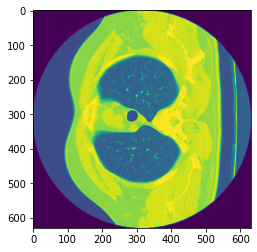

In [ ]:
plt.imshow(nib.load('/content/rp_im/4.nii.gz').get_fdata()[:, :, 30])

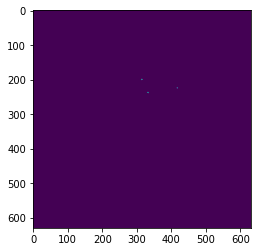

In [ ]:
plt.imshow(nib.load('/content/rp_msk/4.nii.gz').get_fdata()[:, :, 30])

[0. 1.]


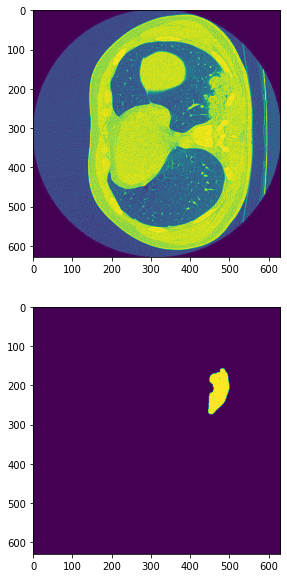

In [ ]:
d = np.load('Covid/3_124.npz')
img, label = d['image'], d['label']
print(np.unique(label))
img = (img - img.min()) / (img.max() - img.min())

f, ax = plt.subplots(2,1, figsize=(20, 10)) 

ax[0].imshow(img)
ax[1].imshow(label)
plt.show()

# Config and settings

In [ ]:
#!g1.1
from utils import Config 
cfg = Config()

cfg.core_dir = 'Covid/'
cfg.save_folder = ''
cfg.save_name = 'covid'

# Setting seed
cfg.seed = 42

# Model settings
cfg.pretrained = True
cfg.epochs = 12
cfg.lr = 3e-4

# Dataloading
cfg.batch_size = 8
cfg.val_size = 0.2

# Cross-validation
cfg.kfold = False
# cfg.n_splits = 3
# cfg.fold_number = 1

# Data loading

In [ ]:
#!g1.1
cfg.pre_transforms = [
    # dict(
    #     name="PadIfNeeded",
    #     params=dict(
    #         min_height=640,
    #         min_width=640,
    #         p=1.0,
    #     )
    # ),
    dict(
        name="Resize",
        params=dict(
            height=512,
            width=512,
            p=1.0,
        )
    ),
]

cfg.augmentations = [
    # dict(
    #     name="HorizontalFlip",
    #     params=dict(
    #         p=0.5)
    # ),
    # dict(
    #     name="VerticalFlip",
    #     params=dict(
    #         p=0.5)
    # ),
#     dict(
#         name="ElasticTransform",
#         params=dict(
#             p=0.5)
#     ),
    # dict(
    #     name="RandomRotate90",
    #     params=dict()
    # ),
#     class albumentations.augmentations.geometric.transforms.ElasticTransform 
]

cfg.post_transforms = []

In [ ]:
from utils import get_loaders
t = get_loaders(cfg)
a = next(iter(t[0]))
a[0].shape, a[1].shape

(torch.Size([8, 1, 512, 512]), torch.Size([8, 1, 512, 512]))

In [ ]:
a[0].numpy()[0][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

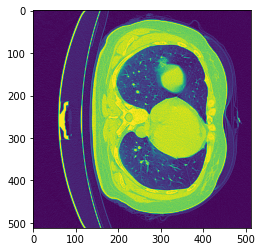

In [ ]:
plt.imshow(a[0].numpy()[1][0] * 255)

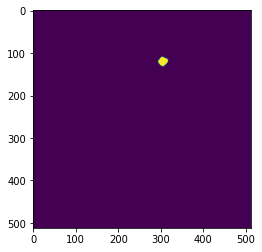

In [ ]:
plt.imshow(a[1].numpy()[1][0])

# Train


In [ ]:
#!g1.1
cfg.device = 'cuda' if torch.cuda.is_available() else 'cpu'
cfg.model = 'Unet' #@param ['DeepLabV3', 'Unet', 'UnetPlusPlus']
cfg.backbone = 'resnet50' #@param [ 'None', 'resnet101', 'resnet50', 'resnet34', 'resnext101_32x4d', 'resnet152', 'efficientnet-b7', 'efficientnet-b6', 'efficientnet-b5']
cfg.in_channels = 1
cfg.num_classes = 1
cfg.layers_to_freeze = 4
cfg.max_early_stopping = 2

cfg.metric = 'IoUScore' #@param ['IoUScore', 'IoUScoreBinary', 'DiceScore']
cfg.metric_params = dict()
cfg.criterion = 'IoULoss' #@param ['IoULoss', 'BCELoss', 'DiceLoss', 'FocalLoss']
cfg.criterion_params = dict()

cfg.optimizer = 'Adam'
cfg.optimizer_params = dict(
    lr=cfg.lr
)

from utils.datagenerator import get_paths


cfg.scheduler = 'OneCycleLR'
cfg.scheduler_params = dict(
    max_lr=cfg.lr,
    epochs=cfg.epochs,
    steps_per_epoch=len(get_paths(cfg)) // cfg.batch_size
)

# cfg.scheduler = None
# cfg.scheduler_params = dict(
#     lr=cfg.lr
# )

In [ ]:
#!g1.1
!nvidia-smi

Sun Oct 30 19:13:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W /  70W |  13474MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!g1.1
!ls weights

baseline-IoULoss-0.055090967391399626.pth
baseline-IoUScore-0.9731302974071908.pth
baseline-IoUScore-0.9765783492555009.pth
covid-IoUScore-0.9503718795983688.pth
covid.pth
lung.pth


In [ ]:
#!g1.1
from train_functions import run

# cfg.pretrained = 'weights/UnetPP-efnb7-1024-of-IoULoss-0.18118978592387416.pth'
cfg.save(replace=True)
model = run(cfg, use_wandb=False)

Epoch #1


100%|██████████| 355/355 [04:25<00:00,  1.34it/s]


      Score    |    Loss
Train: 0.127268 | 0.981096


100%|██████████| 83/83 [00:31<00:00,  2.63it/s]


Val: 0.416384 | 0.986626

Epoch #2


100%|██████████| 355/355 [04:26<00:00,  1.33it/s]


      Score    |    Loss
Train: 0.696271 | 0.961847


100%|██████████| 83/83 [00:31<00:00,  2.65it/s]


Val: 0.730546 | 0.958650

Epoch #3


100%|██████████| 355/355 [04:25<00:00,  1.34it/s]


      Score    |    Loss
Train: 0.924927 | 0.614457


100%|██████████| 83/83 [00:31<00:00,  2.66it/s]


Val: 0.954301 | 0.420683

Epoch #4


100%|██████████| 355/355 [04:26<00:00,  1.33it/s]


      Score    |    Loss
Train: 0.953712 | 0.353160


100%|██████████| 83/83 [00:31<00:00,  2.67it/s]


Val: 0.956247 | 0.382975

Epoch #5


  1%|          | 3/355 [00:02<04:35,  1.28it/s]


KeyboardInterrupt: ignored

# Draw preds

In [ ]:
!unzip /content/zenodo.zip -d /content/

Archive:  /content/zenodo.zip
  inflating: /content/coronacases_001.nii.gz  
  inflating: /content/coronacases_002.nii.gz  
  inflating: /content/coronacases_003.nii.gz  
  inflating: /content/coronacases_004.nii.gz  
  inflating: /content/coronacases_005.nii.gz  
  inflating: /content/coronacases_006.nii.gz  
  inflating: /content/coronacases_007.nii.gz  
  inflating: /content/coronacases_008.nii.gz  
  inflating: /content/coronacases_009.nii.gz  
  inflating: /content/coronacases_010.nii.gz  
  inflating: /content/radiopaedia_10_85902_1.nii.gz  
  inflating: /content/radiopaedia_10_85902_3.nii.gz  
  inflating: /content/radiopaedia_14_85914_0.nii.gz  
  inflating: /content/radiopaedia_27_86410_0.nii.gz  
  inflating: /content/radiopaedia_29_86490_1.nii.gz  
  inflating: /content/radiopaedia_29_86491_1.nii.gz  
  inflating: /content/radiopaedia_36_86526_0.nii.gz  
  inflating: /content/radiopaedia_40_86625_0.nii.gz  
  inflating: /content/radiopaedia_4_85506_1.nii.gz  
  inflating: /c

In [ ]:
!wget https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip -O /content/zenodo.zip

--2022-10-30 18:46:47--  https://zenodo.org/record/3757476/files/COVID-19-CT-Seg_20cases.zip
Resolving zenodo.org (zenodo.org)... 188.184.117.155
Connecting to zenodo.org (zenodo.org)|188.184.117.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1105395143 (1.0G) [application/octet-stream]
Saving to: ‘/content/zenodo.zip’

/content/zenodo.zip 100%[===================>]   1.03G  29.8MB/s    in 36s     

2022-10-30 18:47:25 (28.9 MB/s) - ‘/content/zenodo.zip’ saved [1105395143/1105395143]



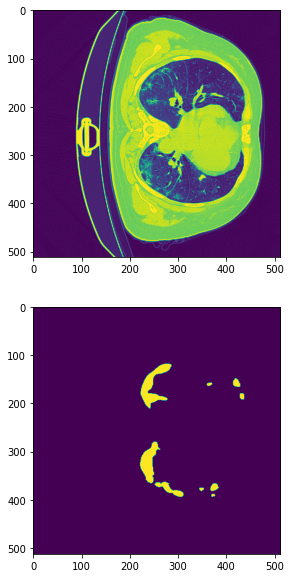

In [ ]:
from utils.cfgtools import get_model
import nibabel as nib
model = get_model(cfg)(cfg)

model.load_state_dict(torch.load('weights/covid.pth'))
model.eval()

# d = np.load('Covid/3_124.npz')
# img, label = d['image'], d['label']
img = nib.load('/content/coronacases_001.nii.gz').get_fdata()[:, :, 150]
img = window_image(img)
img = (img - img.min()) / (img.max() - img.min())

mask = nib.load('/content/masks/coronacases_001.nii.gz').get_fdata()[:, :, 150]

f, ax = plt.subplots(2,1, figsize=(20, 10)) 

ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

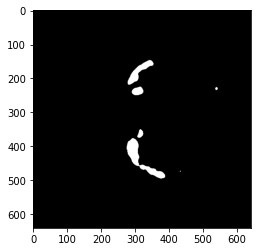

In [ ]:
pred = model(torch.tensor(t(image=img.astype(np.float32))['image']).unsqueeze(0).unsqueeze(0)).detach()
plt.imshow(pred.numpy()[0][0] > 0.5, cmap='gray')

In [ ]:
img.shape

(512, 512)

In [ ]:
t = A.Resize(640, 640, p=1)

In [ ]:
# !wget https://zenodo.org/record/3757476/files/Infection_Mask.zip -O /content/masks.zip
!mkdir /content/masks
!unzip /content/masks.zip -d /content/masks

mkdir: cannot create directory ‘/content/masks’: File exists
Archive:  /content/masks.zip
replace /content/masks/coronacases_001.nii.gz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/masks/coronacases_001.nii.gz  
  inflating: /content/masks/coronacases_002.nii.gz  
  inflating: /content/masks/coronacases_003.nii.gz  
  inflating: /content/masks/coronacases_004.nii.gz  
  inflating: /content/masks/coronacases_005.nii.gz  
  inflating: /content/masks/coronacases_006.nii.gz  
  inflating: /content/masks/coronacases_007.nii.gz  
  inflating: /content/masks/coronacases_008.nii.gz  
  inflating: /content/masks/coronacases_009.nii.gz  
  inflating: /content/masks/coronacases_010.nii.gz  
  inflating: /content/masks/radiopaedia_10_85902_1.nii.gz  
  inflating: /content/masks/radiopaedia_10_85902_3.nii.gz  
  inflating: /content/masks/radiopaedia_14_85914_0.nii.gz  
  inflating: /content/masks/radiopaedia_27_86410_0.nii.gz  
  inflating: /content/masks/radiopaedia_29_86490_1.ni

In [ ]:
!ls /content

coronacases_001.nii.gz	radiopaedia_10_85902_1.nii.gz
coronacases_002.nii.gz	radiopaedia_10_85902_3.nii.gz
coronacases_003.nii.gz	radiopaedia_14_85914_0.nii.gz
coronacases_004.nii.gz	radiopaedia_27_86410_0.nii.gz
coronacases_005.nii.gz	radiopaedia_29_86490_1.nii.gz
coronacases_006.nii.gz	radiopaedia_29_86491_1.nii.gz
coronacases_007.nii.gz	radiopaedia_36_86526_0.nii.gz
coronacases_008.nii.gz	radiopaedia_40_86625_0.nii.gz
coronacases_009.nii.gz	radiopaedia_4_85506_1.nii.gz
coronacases_010.nii.gz	radiopaedia_7_85703_0.nii.gz
COVID19_1110		ReadMe.txt
drive			rp_im
masks			rp_msk
masks.zip		sample_data
mosmed.zip		zenodo.zip
